In [1]:
# some general settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np

pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=6,threshold=5000,linewidth=200,suppress=True)

In [2]:
# function to walk through directories and process spam-files
# only takes text after the first newline!! (dus dit is mijn data-opschoondeel: de header wordt overgeslagen)
import os

def read_files(path):
    emails_text = []
    for (dirpath, dirs_in_path, file_names) in os.walk(path):
        for file_name in file_names:
            lines = []
            file_to_open = os.path.join(dirpath,file_name)
            with open(file_to_open, 'r') as spam_file:
                indicator = False
                for line in spam_file:
                    if indicator:
                        lines.append(line)
                    elif line == '\n':
                        indicator = True
            emails_text.append("\n".join(lines))
    return emails_text

In [3]:
#functie om data uit file in een dataframe te stoppen en df te returnen
def df_to_append(location,class_spam,email_text):
    df = pd.DataFrame(columns=['location','class_spam','email'])
    df['email'] = email_text
    df['location'] = location
    df['class_spam'] = class_spam
    return df

In [4]:
# location of data, and 0=ham, 1=spam
input_emails = [
                ['data\\beck-s',      0L],
                ['data\\farmer-d',    0L],
                ['data\\kaminski-v',  0L],
                ['data\\kitchen-l',   0L],
                ['data\\lokay-m',     0L],
                ['data\\williams-w3', 0L],
                ['data\\BG',          1L],
                ['data\\GP',          1L],
                ['data\\SH',          1L]
]

In [5]:
#aanmaken van spam/ham dataset:

# 1. definieren kolomnamen
column_names = ['location','class_spam','email']

# 2. aanmaken dataframe
data = pd.DataFrame(columns=column_names)

# 3. loop alle locaties af, haal emailtext per locatie op, stop die in een df en append die dan in 1 final df
for location, class_spam in input_emails:
    email_text = read_files(location)
    df_to_add = df_to_append(location,class_spam,email_text)
    data = data.append(df_to_add,ignore_index=True)

In [ ]:
# sla data in juiste vorm op, zodat ik dat niet telkens opnieuw hoef te doen
from sklearn.externals import joblib
joblib.dump(data, 'data.pkl')

# om data weer te kunnen loaden moet regel hieronder geuncomment worden
#data = joblib.load('data.pkl')

In [6]:
# aanmaken van train- en testset, location heb ik er nu buitengehouden
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['email'], data['class_spam'], test_size=0.20, random_state=42)

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.grid_search import GridSearchCV 
from sklearn.grid_search import RandomizedSearchCV

count_vect = CountVectorizer(encoding="latin-1") #utf-8 encoding werkte niet
tfidf = TfidfTransformer()
mnb = MultinomialNB()
svc = LinearSVC()

steps = [
            ('count_vect', count_vect),
            ('tfidf', tfidf),
            ('mnb',mnb)
            #('svc',svc)
]

pipeline = Pipeline(steps)

# parameters die goed werkten op deze dataset:
# ngram:(1,2), min_df: 1, max_df:0.2
parameters = {
                'count_vect__ngram_range':[(1,2)],                   #[(1,1),(1,2),(1,3)]
                'count_vect__min_df':[1],                            #[1,5,10]
                'count_vect__max_df':[0.2],                          #[0.2,0.5,1.0]
                'tfidf__sublinear_tf':[False]                           #[True,False]
                #,'svc__C':[0.1,1,10,1000],
                #'svc__tol':[1e-3,1e-4,1e-5]
}

grid_search = GridSearchCV(pipeline, parameters, cv=2, n_jobs=1, scoring='roc_auc', verbose=5) #scoring measure is hier AUC ipv accuracy

In [18]:
grid_search.fit(X_train,y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] count_vect__max_df=0.2, count_vect__min_df=1, tfidf__sublinear_tf=False, count_vect__ngram_range=(1, 2) 
[CV]  count_vect__max_df=0.2, count_vect__min_df=1, tfidf__sublinear_tf=False, count_vect__ngram_range=(1, 2), score=0.999545 - 1.2min
[CV] count_vect__max_df=0.2, count_vect__min_df=1, tfidf__sublinear_tf=False, count_vect__ngram_range=(1, 2) 
[CV]  count_vect__max_df=0.2, count_vect__min_df=1, tfidf__sublinear_tf=False, count_vect__ngram_range=(1, 2), score=0.999689 - 1.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(steps=[('count_vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding='latin-1', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
   ...False,
         use_idf=True)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'count_vect__max_df': [0.2], 'count_vect__min_df': [1], 'tfidf__sublinear_tf': [False], 'count_vect__ngram_range': [(1, 2)]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=5)

In [19]:
#bij countvect: min_df = 1, max_df = 0.2 en ngrams = (1,2)
grid_search.best_estimator_

Pipeline(steps=[('count_vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding='latin-1', input=u'content',
        lowercase=True, max_df=0.2, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
   ...False,
         use_idf=True)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [ ]:
#opslaan van best_estimator van de gridsearch
#bij countvect: min_df = 1, max_df = 0.2 en ngrams = (1,2)
joblib.dump(grid_search.best_estimator_, 'countvect_tfidf_mnbayes_best_est.pkl')
# grid_search_best = joblib.load('countvect_tfidf_mnbayes_best_est.pkl')

In [28]:
# hoe is de accuracy: printen confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, grid_search.predict(X_test),labels=[1,0])
print conf_matrix

[[6580    6]
 [  76 3754]]


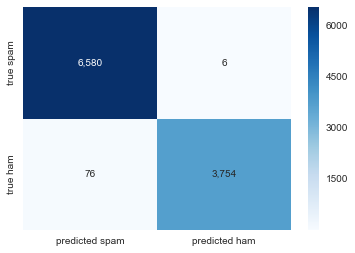

In [39]:
#visualiseren confusion matrix met seaborn
%matplotlib inline
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt=',.0f', cmap="Blues", xticklabels=['predicted spam','predicted ham'], yticklabels=['true spam', 'true ham'])

In [41]:
# hoeveel ga er nu echt fout, zowel FN als FP
truespam_predham = conf_matrix[0,1]
truespam_predspam = conf_matrix[0,0]
trueham_predspam = conf_matrix[1,0]
trueham_predham = conf_matrix[1,1]
print "True spam, maar predicted ham: %s = False Negatives" %(truespam_predham)
print "True ham, maar predicted spam: %s = False Positives" %(trueham_predspam)

True spam, maar predicted ham: 6 = False Negatives
True ham, maar predicted spam: 76 = False Positives


C:\Datascience\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


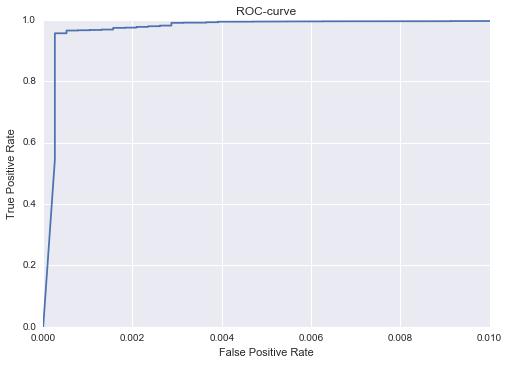

In [25]:
# printen roc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, grid_search.predict_proba(X_test)[:,1])

from matplotlib import pyplot as plt
plt.plot(fpr, tpr)
plt.xlim([0, 0.01])
plt.ylim([0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(loc="lower right")
plt.show()